# Core: Training Weather prediction model using PhysicsNeMo

In this notebook, we will emulate global weather system using a data-driven AI model. This notebook introduces FourCastNet architecture which is built using the Adaptive Fourier Neural Operators. This notebook is an extension of the simple data-driven problem we solved in [this notebook](../darcy_flow/Notebook_1.ipynb).

#### Contents of the Notebook
- [Problem Statement](#Problem-Statement:-Developing-an-AI-model-for-weather-forecasting-using-FourCastNet)
- [FourCastNet (Adaptive Fourier Neural Operator)](#FourCastNet-(Adaptive-Fourier-Neural-Operator))
- [Solving Weather Forecasting using FourCastNet](#Solving-weather-forecasting-using-FourCastNet)
    - [Step 1: Setup DistributedManager and data loaders](#Step-1:-Setup-DistributedManager-and-data-loaders)
    - [Step 2: Initialize the AFNO model](#Step-2:-Initialize-the-AFNO-model)
    - [Step 3: Setup custom loss function and validation utilities](#Step-3:-Setup-custom-loss-function-and-validation-utilities)
    - [Step 4: Setup distributed data parallel training, initialize optimizer and scheduler](#Step-4:-Setup-distributed-data-parallel-training,-initialize-optimizer-and-scheduler)
    - [Step 5: Apply optimizations to speed-up training](#Step-5:-Apply-optimizations-to-speed-up-training)
    - [Step 6: Setup training loop and train the model](#Step-6:-Setup-training-loop-and-train-the-model)
    - [Step 7: Perform inference on the trained model](#Step-7:-Perform-inference-on-the-trained-model)

#### Learning Objectives
- How to use PhysicsNeMo to setup a weather prediction model
- How to use Distributed and optimization utilities from PhysicsNeMo
- How to perform inference on trained models

## Problem Statement: Developing an AI model for weather forecasting using FourCastNet

<strong>FourCastNet</strong>, short for Fourier ForeCasting Neural Network, is a global data-driven weather forecasting model that provides accurate short to medium range global predictions at 0.25° resolution. FourCastNet generates a week long forecast in less than 2 seconds, orders of magnitude faster than the ECMWF Integrated Forecasting System (IFS), a state-of-the-art Numerical Weather Prediction (NWP) model, with comparable or better accuracy. It is trained on a small subset of the ERA5 reanalysis dataset from the ECMWF, which consists of hourly estimates of several atmospheric variables at a latitude and longitude resolution of 0.25°. Given an initial condition from the ERA5 dataset as input, FourCastNet recursively applies an Adaptive Fourier Neural Operator (AFNO) network to predict their dynamics at later time steps. In the current iteration, FourCastNet forecasts 20 atmospheric variables. These variables, listed in the table below, are sampled from the ERA5 dataset at a temporal resolution of 6 hours.

<center><img src="images/fcn_table.png" alt="Drawing" style="width:600px" /></center>

The goal of FourCastNet is to forecast modeled variables on a short time scale of up to 10 days. FourCastNet is initialized using an initial condition from the ERA5 reanalysis dataset.

## FourCastNet (Adaptive Fourier Neural Operator) 

FourCastNet uses Adaptive Fourier Neural Operator (AFNO) model. This particular neural network architecture is appealing as it is specifically designed for high-resolution inputs and synthesizes several key recent advances in Deep Learning into one model. Namely, it combines the Fourier Neural Operator (FNO) learning approach of <a href="https://arxiv.org/abs/2010.08895" rel="nofollow">Li et al. [2021a]</a>, which has been shown to perform well in modeling challenging PDE systems, with a powerful ViT backbone.

<center><img src="images/fcn_arch.webp" alt="Drawing" style="width:900px" /></center>

The AFNO model is unique in that it frames the mixing operation as continuous global convolution, implemented efficiently in the Fourier domain with FFTs, which allows modeling dependencies across spatial and channel dimensions flexibly and scalably. With such a design, the spatial mixing complexity is reduced to $O(N log N)$, where $N$ is the number of image patches or tokens. This scaling allows the AFNO model to be well-suited to high-resolution data at the current 0.25◦ resolution. In the original FNO formulation, the operator learning approach showed impressive results in solving turbulent Navier-Stokes systems, so incorporating this into a data-driven atmospheric model is a natural choice.

First, the input variables on the 720 × 1440 latitude-longitude grid are projected to a 2D grid (h × w) of patches (with a small patch size p × p, where e.g., p = 8), with each patch represented as a d-dimensional token. Then, the sequence of patches are fed, along with a positional encoding, to a series of AFNO layers. Each layer, given an input tensor of patches  $h×w×d$ , performs spatial mixing followed by channel mixing. Spatial mixing happens in the Fourier domain as follows: 

<strong>Step 1</strong> : Transform tokens to the Fourier domain with 
$$z_{m,n} = [DFT(X)]_{m,n} $$
where $m, n$ index the patch location and DFT denotes a 2D discrete Fourier transform.

<strong>Step 2</strong> : Apply token weighting in the Fourier domain, and promote sparsity with a Soft-Thresholding and Shrinkage operation as
$$\tilde{z}_{m,n} = S_λ(MLP(z_{m,n}))$$
where $S_λ(x) = sign(x) max(|x| − λ, 0)$ with the sparsity controlling parameter $λ$, and MLP() is a 2-layer
multi-layer perceptron with block-diagonal weight matrices, which are shared across all patches.

<strong>Step 3</strong> : Inverse Fourier to transform back to the patch domain and add a residual connection as
$$y_{m,n} = [IDFT(\tilde{Z})]_{m,n} + X_{m,n} $$

## Solving weather forecasting using FourCastNet

With theory and basics covered, let's look into how to code up a weather forecasting example using PhysicsNeMo. Training these weather prediction models require handling very large volumes of data and typically involve training on multiple GPUs. With PhysicsNeMo we aim to provide utilities to facilitate this and simplify the process of setting up an optimized, scalable training pipeline for such large problems. In this example we will see the usage distributed utilities, optimization wrappers and dataloaders from PhysicsNeMo. 

In addition to the optimized utilities, PhysicsNeMo also has several implementations of weather models developed within NVIDIA and from the community to enable your exploration in this space and empower you to do faster science using deep learning and PhysicsNeMo. 

<center><img src="images/global-weather-models.png" alt="Drawing" style="width:1100px" /></center>

Now, let's start with a few imports and loading the configuration.

In [1]:
import os
os.environ["RANK"]="0"
os.environ["WORLD_SIZE"]="1"
os.environ["MASTER_ADDR"]="localhost"
os.environ["MASTER_PORT"]="15678"

import torch
import hydra
import wandb
import matplotlib.pyplot as plt

from torch.nn.parallel import DistributedDataParallel
from omegaconf import DictConfig

from physicsnemo.models.afno import AFNO
from physicsnemo.datapipes.climate import ERA5HDF5Datapipe
from physicsnemo.distributed import DistributedManager
from physicsnemo.utils import StaticCaptureTraining, StaticCaptureEvaluateNoGrad

from physicsnemo.launch.logging.mlflow import initialize_mlflow
from physicsnemo.launch.logging import LaunchLogger, PythonLogger
from physicsnemo.launch.utils import load_checkpoint, save_checkpoint

from apex import optimizers

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)


In [2]:
from hydra import compose, initialize

initialize(version_base="1.3", config_path="conf")
cfg = compose(config_name="config_weather")

### Step 1: Setup DistributedManager and data loaders

We start with initializing utilities for distributed training. For this session, you have access to only 1 GPU, nevertheless we will setup the training in a distributed data parallel. This way, in the presence of multiple GPUs, we can minimize the time per epoch. Distributed utilities in PhysicsNeMo are designed to simplify implementation of parallel training and make inference scripts easier by providing a unified way to configure and query parameters associated with the distributed environment. The utilities in `physicsnemo.distributed` build on top of the utilities from `torch.distributed` and abstract out some of the complexities of setting up a distributed execution environment. For more details refer the documentation on [`physicsnemo.distributed`](https://docs.nvidia.com/deeplearning/physicsnemo/physicsnemo-core/api/physicsnemo.distributed.html).

Once the `DistributedManager` is initialized, it can be used anytime in your training loop without reinitialization. The distributed manager from PhysicsNeMo will enable you query `device_ids`, `output_device`, `broadcast_buffers`, `find_unused_parameters` etc. parameters that are typically required to setup a distributed PyTorch training workflow. 

We also initialize dataloaders required to load the weather data to train this model. We will use a optimized dataloader from PhysicsNeMo that is built on top of NVIDIA DALI. This dataloader allows fast data loading of weather datasets and also enables asynchronous and parallel access of several data streams. Notice the use of `dist.device`, `dist.rank` and `dist.world_size`. 

#### Note
While the actual AFNO model is trained on 20 channels of atmospheric data from 1979-2018, for the purposes of this notebook, we will only use a subset of this data which includes some samples from the year 1980 for channels U10 (10m u-component of wind), V10 (10m v-component of wind) and T2m (2m temperature). 

In [3]:
DistributedManager.initialize()
dist = DistributedManager()
mlflow_cfg = cfg.get("logging", {}).get("mlflow", {})
if mlflow_cfg.pop("use_mlflow", False):
    initialize_mlflow(**mlflow_cfg)
    LaunchLogger.initialize(use_mlflow=True)
# LaunchLogger.initialize(use_mlflow=cfg.use_mlflow)  # PhysicsNeMo launch logger
logger = PythonLogger("main")  # General python logger

datapipe = ERA5HDF5Datapipe(
    data_dir="../../source_code/core/datasets/test/",
    stats_dir="../../source_code/core/datasets/stats/",
    channels=[i for i in range(3)],
    num_samples_per_year=128,
    batch_size=2,
    patch_size=(8, 8),
    num_workers=cfg.num_workers_train,
    device=dist.device,
    process_rank=dist.rank,
    world_size=dist.world_size,
)

logger.success(f"Loaded datapipe of size {len(datapipe)}")
if dist.rank == 0:
    logger.file_logging()
    validation_datapipe = ERA5HDF5Datapipe(
        data_dir="../../source_code/core/datasets/out_of_sample/",
        stats_dir="../../source_code/core/datasets/stats/",
        channels=[i for i in range(3)],
        num_steps=8,
        num_samples_per_year=4,
        batch_size=1,
        patch_size=(8, 8),
        device=dist.device,
        num_workers=cfg.num_workers_validation,
        shuffle=False,
    )

logger.success(f"Loaded validaton datapipe of size {len(validation_datapipe)}")

### Step 2: Initialize the AFNO model

Next, we initialize the AFNO model from PhysicsNeMo with the appropriate parameters required for the FourCastNet. 

In [4]:
fcn_model = AFNO(
    inp_shape=[720, 1440],
    in_channels=3,
    out_channels=3,
    patch_size=[8, 8],
    embed_dim=768,
    depth=12,
    num_blocks=8,
).to(dist.device)

### Step 3: Setup custom loss function and validation utilities

Next, we define the loss function for training and the validation step.

In [5]:
def loss_func(x, y, p=2.0):
    yv = y.reshape(x.size()[0], -1)
    xv = x.reshape(x.size()[0], -1)
    diff_norms = torch.linalg.norm(xv - yv, ord=p, dim=1)
    y_norms = torch.linalg.norm(yv, ord=p, dim=1)

    return torch.mean(diff_norms / y_norms)

os.makedirs("./results/", exist_ok=True)
@torch.no_grad()
def validation_step(eval_step, fcn_model, datapipe, channels=[0, 1], epoch=0):
    loss_epoch = 0
    num_examples = 0  # Number of validation examples
    # Dealing with DDP wrapper
    if hasattr(fcn_model, "module"):
        fcn_model = fcn_model.module
    fcn_model.eval()
    for i, data in enumerate(datapipe):
        invar = data[0]["invar"].detach()
        outvar = data[0]["outvar"].cpu().detach()
        predvar = torch.zeros_like(outvar)

        for t in range(outvar.shape[1]):
            output = eval_step(fcn_model, invar)
            invar.copy_(output)
            predvar[:, t] = output.detach().cpu()

        num_elements = torch.prod(torch.Tensor(list(predvar.shape[1:])))
        loss_epoch += torch.sum(torch.pow(predvar - outvar, 2)) / num_elements
        num_examples += predvar.shape[0]

        # Plotting
        if i == 0:
            predvar = predvar.numpy()
            outvar = outvar.numpy()
            for chan in channels:
                plt.close("all")
                fig, ax = plt.subplots(
                    3, predvar.shape[1], figsize=(15, predvar.shape[0] * 5)
                )
                for t in range(outvar.shape[1]):
                    ax[0, t].imshow(predvar[0, t, chan])
                    ax[1, t].imshow(outvar[0, t, chan])
                    ax[2, t].imshow(predvar[0, t, chan] - outvar[0, t, chan])

                fig.savefig(f"./results/era5_validation_channel{chan}_epoch{epoch}.png")

    fcn_model.train()
    return loss_epoch / num_examples

### Step 4: Setup distributed data parallel training, initialize optimizer and scheduler

Here, we setup the distributed data parallel training. `DistributedDataParallel` in PyTorch provides the framework for data parallel training by reducing parameter gradients across multiple worker processes after the backward pass. We will use the previously initialized `DistributedManager` from physicsnemo to set this up. Finally, we also define the optimizer and scheduler for the training. For this example we will use a FusedAdam optimizer and a Cosine annealing for learning rate schedule. 

In [6]:
# Distributed learning
if dist.world_size > 1:
    ddps = torch.cuda.Stream()
    with torch.cuda.stream(ddps):
        fcn_model = DistributedDataParallel(
            fcn_model,
            device_ids=[dist.local_rank],
            output_device=dist.device,
            broadcast_buffers=dist.broadcast_buffers,
            find_unused_parameters=dist.find_unused_parameters,
        )
    torch.cuda.current_stream().wait_stream(ddps)

# Initialize optimizer and scheduler
optimizer = optimizers.FusedAdam(
    fcn_model.parameters(), betas=(0.9, 0.999), lr=0.0005, weight_decay=0.0
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

### Step 5: Apply optimizations to speed-up training

Using the models from PhysicsNeMo enables you to use some optimizations like CUDA Graphs, Automatic Mixed Precision and JIT in an automated fashion. `StaticCaptureTraining` and `StaticCaptureEvaluateNoGrad` decorator will capture the training step function and optimize it for the specified choices. To enable these optimizations, we simply wrap the models forward pass and the evaluation step using these decorators. 

In [7]:
@StaticCaptureEvaluateNoGrad(model=fcn_model, logger=logger, use_graphs=False)
def eval_step_forward(my_model, invar):
    return my_model(invar)

@StaticCaptureTraining(model=fcn_model, optim=optimizer, logger=logger)
def train_step_forward(my_model, invar, outvar):
    # Multi-step prediction
    loss = 0
    # Multi-step not supported
    for t in range(outvar.shape[1]):
        outpred = my_model(invar)
        invar = outpred
        loss += loss_func(outpred, outvar[:, t])
    return loss

/usr/local/lib/python3.12/dist-packages/physicsnemo/utils/capture.py:274: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=scaler_enabled)


### Step 6: Setup training loop and train the model

Once all the required utilities are instantiated and the functions defined, we can setup the training loop as before. We loop through the entire dataset and repeat that for a fixed epochs. For this example, to keep the training time short, we will load a pre-computed checkpoint and train the model only for one epoch.

/usr/lib/python3.12/tarfile.py:2254: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/nvidia/dali/pipeline.py:938: Warning: The external source node '<physicsnemo.datapipes.climate.era5_hdf5.ERA5DaliExternalSource object at 0x7fffecb85a90>' produces 4 outputs, but the outputs at the indices 2, 3 are not used. For best performance, adjust your callback so that it computes only the needed outputs.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/nvidia/dali/pipeline.py:938: Warning: The external source node '<physicsnemo.datapipes.climate.era5_hdf5.ERA5DaliExternalSource object at 0x7ffc210cade0>' produces 4 outputs, but the outputs at the indices 2, 3 are not used. For best performance, adjust your callback so that it computes only the needed outputs.
  warnings.warn(


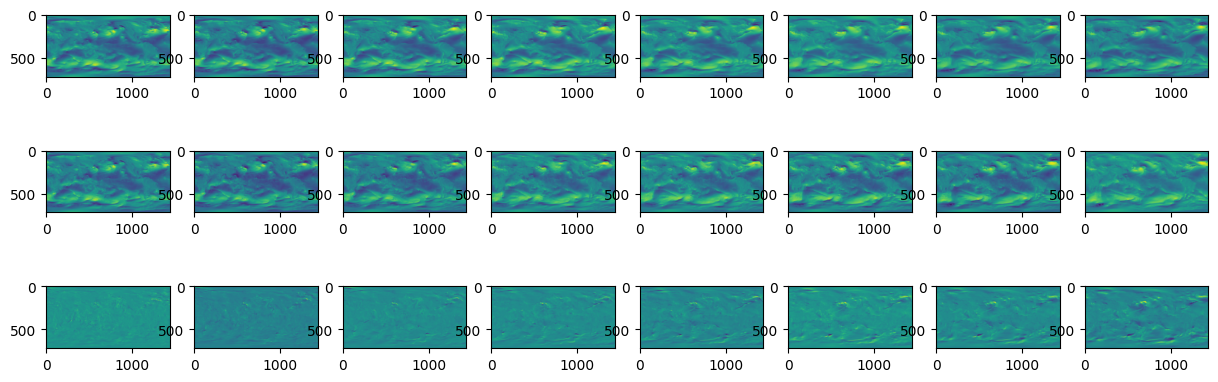

In [8]:
# Attempt to load latest checkpoint if one exists
loaded_epoch = load_checkpoint(
    "./../../source_code/core/checkpoints",
    models=fcn_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=dist.device,
)

# Main training loop
for epoch in range(max(1, loaded_epoch + 1), loaded_epoch + 2):
    # Wrap epoch in launch logger for console / WandB logs
    with LaunchLogger(
        "train", epoch=epoch, num_mini_batch=len(datapipe), epoch_alert_freq=10
    ) as log:
        # === Training step ===
        for j, data in enumerate(datapipe):
            invar = data[0]["invar"]
            outvar = data[0]["outvar"]
            loss = train_step_forward(fcn_model, invar, outvar)
            log.log_minibatch({"loss": loss.detach()})
        log.log_epoch({"Learning Rate": optimizer.param_groups[0]["lr"]})
    if dist.rank == 0:
        # Wrap validation in launch logger for console / WandB logs
        with LaunchLogger("valid", epoch=epoch) as log:
            # === Validation step ===
            error = validation_step(
                eval_step_forward, fcn_model, validation_datapipe, epoch=epoch, channels=[0]
            )
            log.log_epoch({"Validation error": error})
    if dist.world_size > 1:
        torch.distributed.barrier()
    scheduler.step()
    
    # Use PhysicsNeMo Launch checkpoint
    if dist.rank == 0:
        save_checkpoint(
            "./checkpoints",
            models=fcn_model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
        )

if dist.rank == 0:
    logger.info("Finished training!")

You can now visualize the results of the training by looking at the outputs from the `results` directory. That completes the training of our weather prediction data-driven model. 

# Important: Free up GPU Memory!

Run the below cell to free up GPU memory after training the model before moving to the next section.

In [ ]:
import os
os._exit(00)

### Step 7: Perform inference on the trained model

Now that we have trained our AI weather prediction model, this enables us to do some cool science with it. Specifically it enables you to compute ensemble forecasts of the model at a very fast speed compared to a traditional Numerical Weather Prediction models. While showcasing the ensemble computation is out of the scope of this introductory content, below we demonstrate how one can run a simple inference from a trained model. You can refer to [Earth2MIP](https://github.com/NVIDIA/earth2mip) for more information about model scoring and diagnostics. 

In [5]:
# Download the pre-trained checkpoint from NGC registry
# The model is already downloaded for you, but below is a snippets which helps you download for your personal machine.
#!wget 'https://api.ngc.nvidia.com/v2/models/nvidia/modulus/modulus_fcn/versions/v0.2/files/fcn.zip'
!unzip ../../source_code/core/fcn.zip

Archive:  ../../source_code/core/fcn.zip
   creating: fcn/
  inflating: fcn/global_stds.npy     
  inflating: fcn/metadata.json       
  inflating: fcn/fcn.mdlus           

/usr/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=409) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



  inflating: fcn/global_means.npy    
  inflating: fcn/__init__.py         
  inflating: fcn/simple_inference.py  


Once the checkpoint is downloaded, you can run some simple inference with the model. For this example, we have already provided you with a initial condition downloaded from [GFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast).

**Note:** The downloaded checkpoint is a variation of the original AFNO model. The checkpoint hosted on NGC was trained on 26 channels of weather data. 

/usr/lib/python3.12/tarfile.py:2254: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/physicsnemo/registry/model_registry.py:35: DeprecationWarning: Model SFNO is being loaded from the 'modulus.models' group. This probably means it is being exposed from a package that has not yet been updated to use the 'physicsnemo.models' group. This group may be removed in a future release. Please contact the package maintainer to update the entry point.
  cls._shared_state["_model_registry"] = cls._construct_registry()


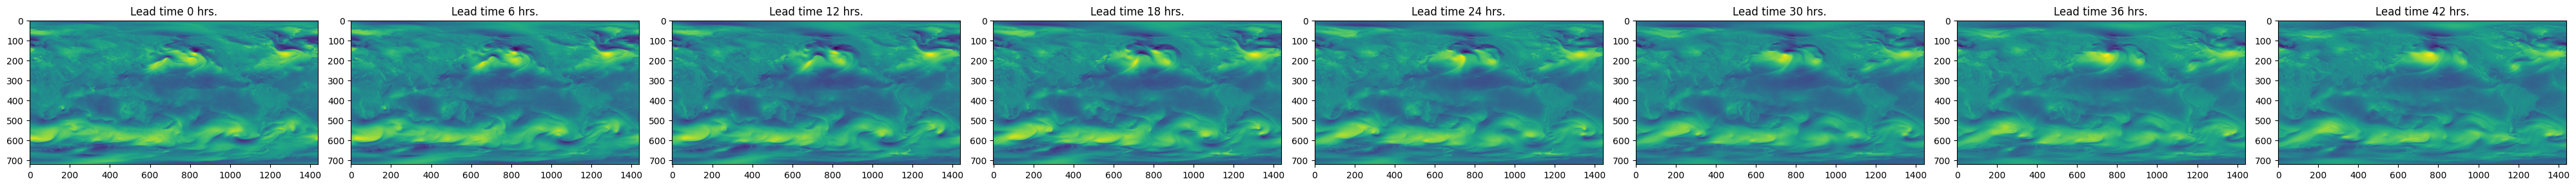

In [6]:
################################# 
# If this cell looks like it's been stuck for sometime, 
# kindly check the output files to verify as it might have completed the file generation.
################################# 

import torch
import xarray
import numpy as np
import physicsnemo
from physicsnemo.distributed import DistributedManager
import matplotlib.pyplot as plt

# Load the PhysicsNeMo checkpoint
# All the meta-data is already stored, so no need to instantiate the model
model = physicsnemo.Module.from_checkpoint("./fcn/fcn.mdlus")
device = DistributedManager().device
model = model.to(device)
model.eval()

# Load the initial condition
ic = xarray.open_dataset("./../../source_code/core/2024-01-01T00_00_00-subsampled.nc")["fields"]

# Load the mean and standard deviation to normalize the inputs
mean = np.load("./fcn/global_means.npy")
std = np.load("./fcn/global_stds.npy")

# Normalize the initial condition
ic_norm = (ic - mean) / std 

# Create a tensor input
ic_norm = torch.from_numpy(ic_norm.values).to(device).to(torch.float32)

# Convert the output from 721x1440 -> 720x1440
ic_norm = ic_norm[:,:,:720,:]

# Generate an auto-regressive inference for 8 rollouts (8*6 = 48hr forecast)
outputs=[]
with torch.no_grad():
    for i in range(8):
        if i == 0:
            out = model(ic_norm)
        else:
            out = model(out)
        outputs.append(out)

# Plot the results
figsize = (5 * 8, 5)
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=figsize,)

for i in range(8):
    out_numpy = outputs[i].cpu().numpy()

    # un-normalize
    out_numpy = out_numpy * std + mean
    axes[i].imshow(out_numpy[0, 0])  # plot the first channel
    axes[i].set_title(f"Lead time {i*6} hrs.")

plt.tight_layout()
plt.savefig("FCN.jpg")

################################# 
# If this cell looks like it's been stuck for sometime, 
# kindly check the output files to verify as it might have completed the file generation.
################################# 

# Important: Free up GPU Memory!

Run the below cell to free up GPU memory after training the model before moving to the next notebook.

In [ ]:
import os
os._exit(00)

--- 

Don't forget to check out additional [Open Hackathons Resources](https://www.openhackathons.org/s/technical-resources) and join our [OpenACC and Hackathons Slack Channel](https://www.openacc.org/community#slack) to share your experience and get more help from the community.

---

# Licensing

Copyright © 2023 OpenACC-Standard.org.  This material is released by OpenACC-Standard.org, in collaboration with NVIDIA Corporation, under the Creative Commons Attribution 4.0 International (CC BY 4.0). These materials may include references to hardware and software developed by other entities; all applicable licensing and copyrights apply.
